### エポックごとの分散

/var/folders/ng/bycwcl5j7s13l6xgltl74w640000gn/T/ipykernel_3331/2261345862.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", len(directories))
/var/folders/ng/bycwcl5j7s13l6xgltl74w640000gn/T/ipykernel_3331/2261345862.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


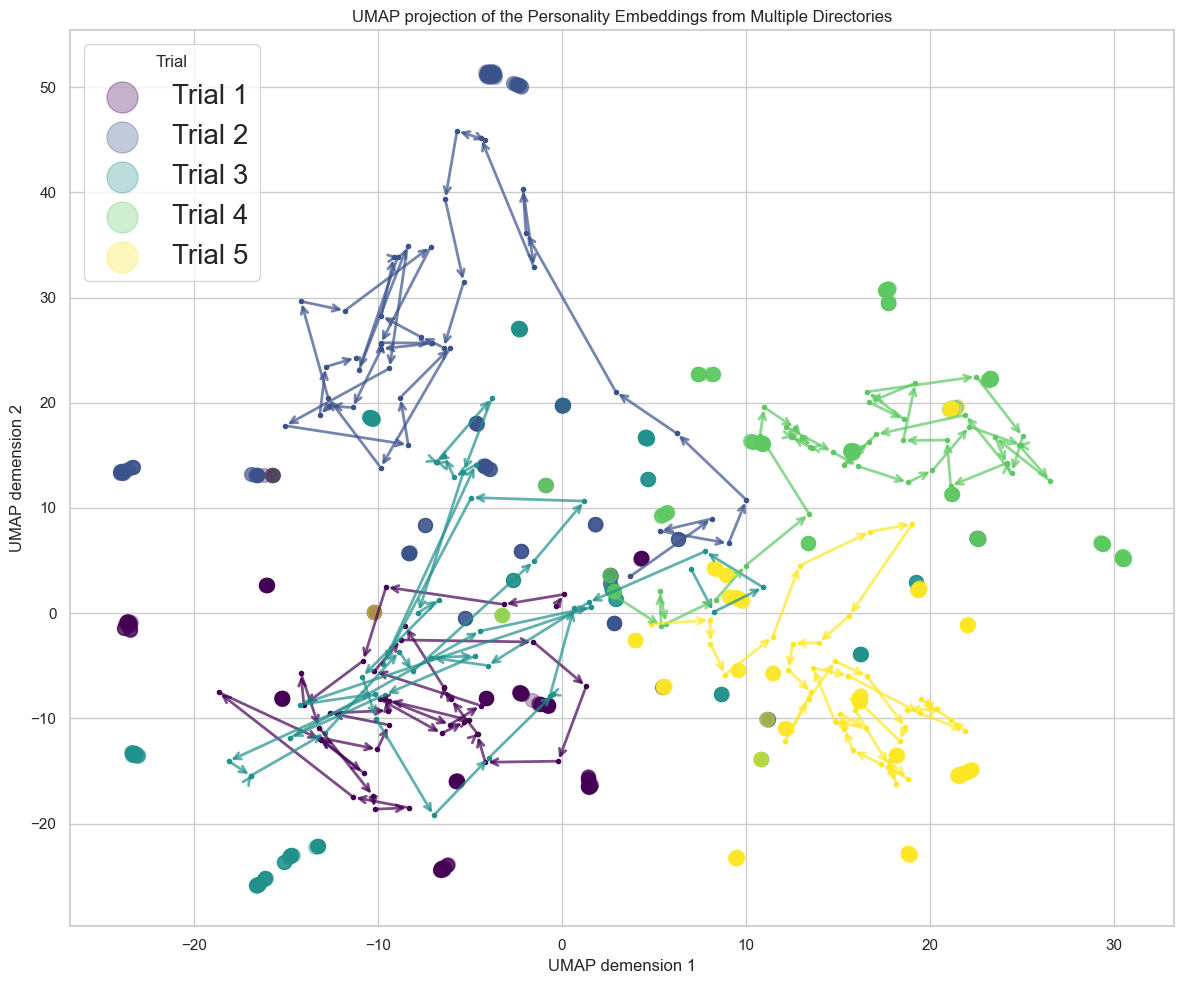

In [94]:
import pandas as pd
import numpy as np
import umap
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def plot_umap(dir_paths):
    # すべてのデータを格納するリスト
    all_data = []

    for dir_path in dir_paths:
        # CSVを読み込む
        df = pd.read_csv(dir_path + 'personality_embeddings.csv')

        # ディレクトリ情報を追加
        df['Directory'] = dir_path

        all_data.append(df)

    # すべてのデータフレームを結合
    combined_df = pd.concat(all_data, ignore_index=True)

    # エンベディングを変換
    embeddings_list = [ast.literal_eval(embedding) for embedding in combined_df["Embedding"].to_numpy()]
    embeddings_array = np.vstack(embeddings_list)

    # UMAPを適用
    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(embeddings_array)

    # UMAP結果をデータフレームに追加
    combined_df['UMAP_1'] = umap_embeddings[:, 0]
    combined_df['UMAP_2'] = umap_embeddings[:, 1]

    # プロットの準備
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 10))

    # ディレクトリごとに色分け
    directories = combined_df['Directory'].unique()
    cmap = plt.cm.get_cmap("viridis", len(directories))

    label_dict = {"./data/EVO_1/": "Trial 1", "./data/EVO_2/": "Trial 2", "./data/EVO_3/": "Trial 3", "./data/EVO_4/": "Trial 4", "./data/EVO_5/": "Trial 5"}

    # Embeddingをプロット
    for i, directory in enumerate(directories):
        group = combined_df[combined_df["Directory"] == directory]

        # エポックごとの平均を計算
        epoch_means = group.groupby('Epoch')[['UMAP_1', 'UMAP_2']].mean().reset_index()

        ax.scatter(
            group["UMAP_1"],
            group["UMAP_2"],
            color=cmap(i),
            label=label_dict[directory],
            marker="o",
            s=100,  # マーカーサイズを大きく
            alpha=0.3
        )

        # エポックの平均点をプロット
        ax.scatter(
            epoch_means["UMAP_1"],
            epoch_means["UMAP_2"],
            color=cmap(i),
            marker=".",
            alpha=1
        )

        # エポック順に矢印を追加
        for j in range(len(epoch_means) - 1):
            ax.annotate("",
                xy=(epoch_means["UMAP_1"].iloc[j+1], epoch_means["UMAP_2"].iloc[j+1]),
                xytext=(epoch_means["UMAP_1"].iloc[j], epoch_means["UMAP_2"].iloc[j]),
                arrowprops=dict(arrowstyle="->", color=cmap(i), alpha=0.7, linewidth=2)
            )

    # 凡例の追加
    legend = plt.legend(title="Trial", fontsize=20, loc="upper left")
    for handle in legend.legendHandles:
        handle._sizes = [500]

    # タイトルの追加
    plt.title("UMAP projection of the Personality Embeddings from Multiple Directories")
    plt.xlabel("UMAP demension 1")
    plt.ylabel("UMAP demension 2")

    # プロットの表示
    plt.tight_layout()
    plt.show()


# ディレクトリのリスト
dir_paths = ['./data/EVO_1/', './data/EVO_2/', './data/EVO_3/', './data/EVO_4/', './data/EVO_5/']
plot_umap(dir_paths)

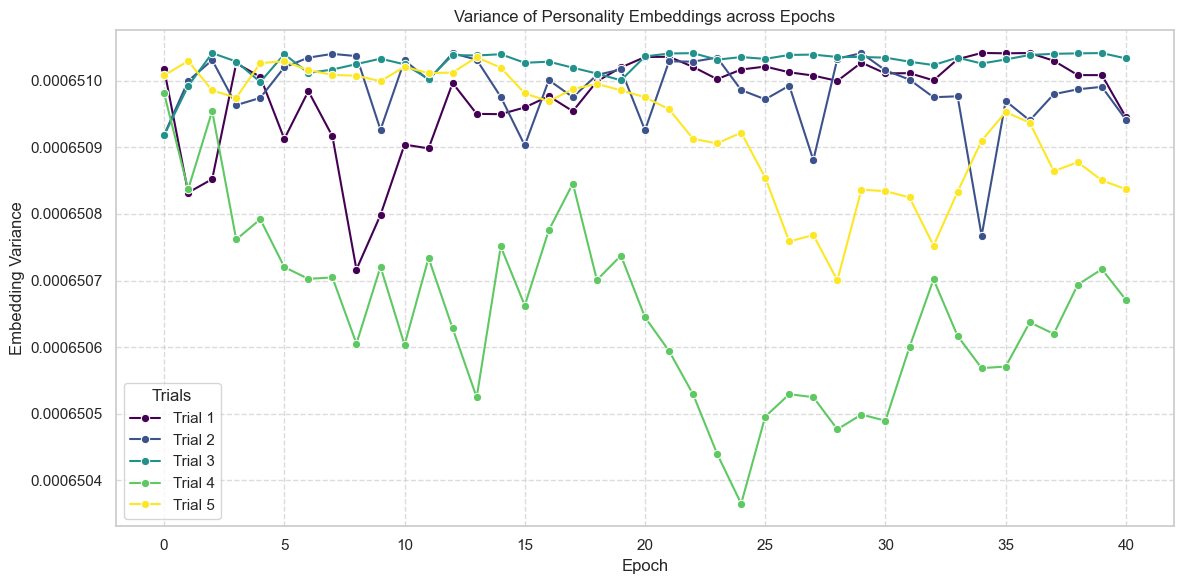

In [93]:
import pandas as pd
import numpy as np
import ast
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def plot_sd(dir_paths):
    plt.figure(figsize=(12, 6))

    # カラーマップの設定
    colors = plt.cm.viridis(np.linspace(0, 1, len(dir_paths)))

    for i, dir_path in enumerate(dir_paths):
        # Load the CSV
        df = pd.read_csv(dir_path + 'personality_embeddings.csv')

        # 各エポックでの埋め込みの分散を計算する関数
        def calculate_embedding_variance(group):
            embeddings = np.array([ast.literal_eval(emb) for emb in group["Embedding"]])
            return np.var(embeddings)

        # エポックごとの分散を計算
        epoch_variances = df.groupby("Epoch").apply(calculate_embedding_variance)

        # プロットの作成
        sns.lineplot(x=epoch_variances.index, y=epoch_variances.values, marker='o', label=f'Trial {i+1}', color=colors[i])

    # プロットの装飾
    plt.title("Variance of Personality Embeddings across Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Embedding Variance")

    # x軸の目盛りを整数に設定
    plt.xticks(range(0, max(epoch_variances.index)+1, 5))

    # グリッドの追加
    plt.grid(True, linestyle='--', alpha=0.7)

    # 凡例の追加
    plt.legend(title="Trials", loc='lower left')

    # プロットの表示
    plt.tight_layout()
    plt.show()

# 使用例
dir_paths = ['./data/EVO_1/', './data/EVO_2/', './data/EVO_3/', './data/EVO_4/', './data/EVO_5/']
plot_sd(dir_paths)

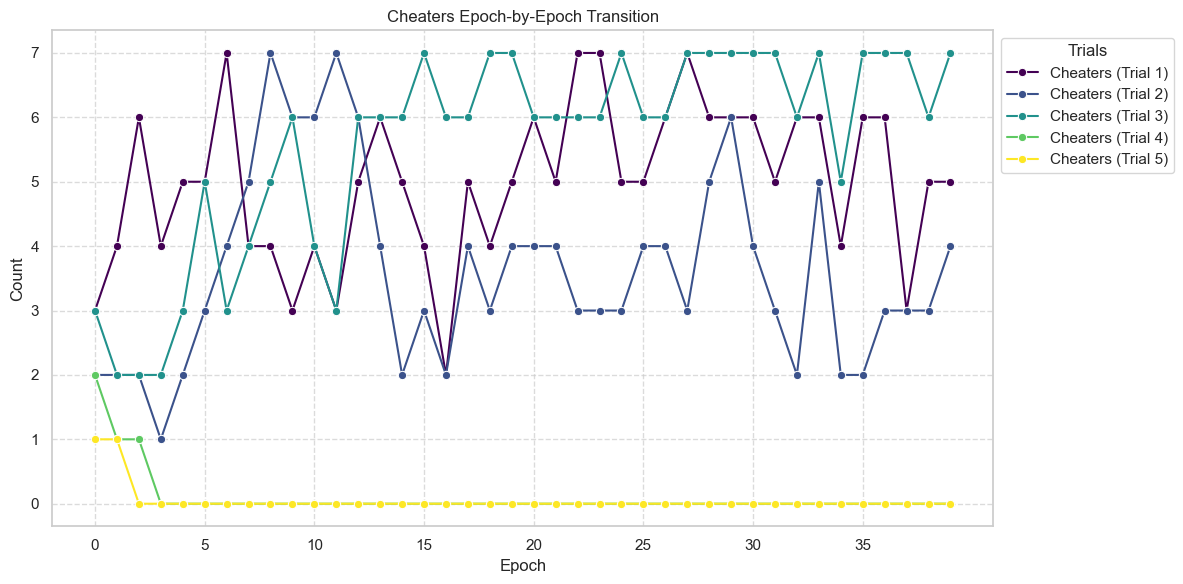

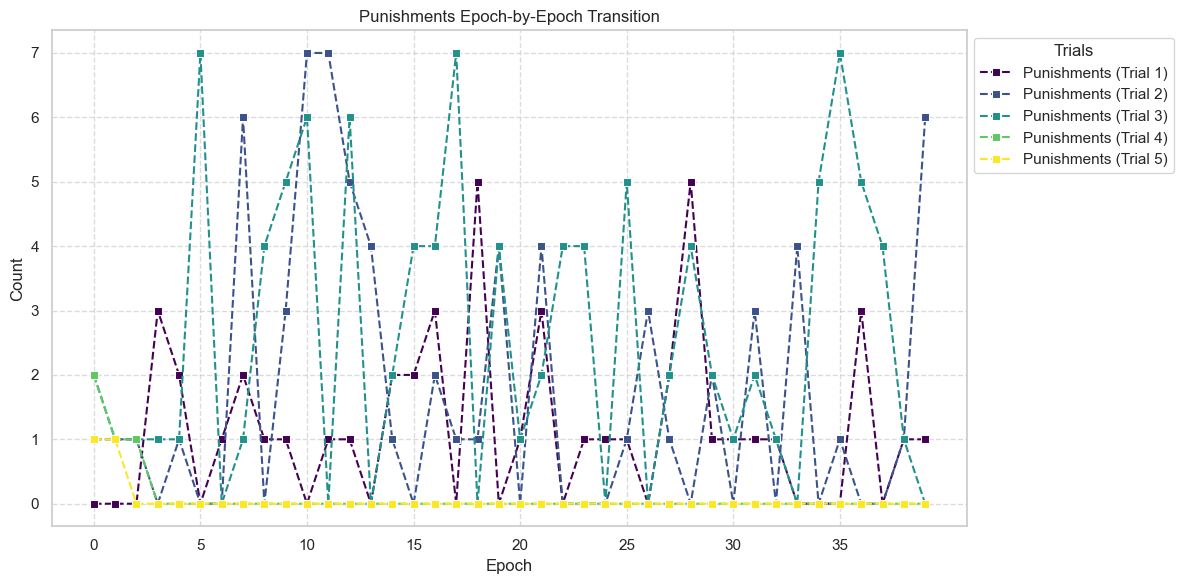

In [92]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def plot_cheaters_punishments(dir_paths, type):
    plt.figure(figsize=(12, 6))

    # カラーマップの設定
    colors = plt.cm.viridis(np.linspace(0, 1, len(dir_paths)))

    for i, dir_path in enumerate(dir_paths):
        # データを格納するリスト
        data = []

        # ログファイルを読み込む
        with open(dir_path + 'log.txt', 'r') as file:
            content = file.read()

        # エポックごとのデータを抽出
        epochs = re.findall(r'All agents take test\. EPOCH (\d+).*?To : .*?', content, re.DOTALL)

        for epoch in epochs:
            epoch_content = re.search(f'All agents take test\. EPOCH {epoch}.*?To : .*?', content, re.DOTALL).group()

            # チートした人数を数える
            cheat_count = epoch_content.count('[CHEATED]')/2

            # パニッシュした人の数を数える（重複を除く）
            punishers = set(re.findall(r'(\w+) has punished by', epoch_content))
            punish_count = len(punishers)

            data.append({'Epoch': int(epoch), 'Cheaters': cheat_count, 'Punishments': punish_count})

        # DataFrameを作成
        df = pd.DataFrame(data)

        # チーターの線をプロット
        if type == "Cheaters":
            sns.lineplot(data=df, x='Epoch', y='Cheaters', marker='o', label=f'Cheaters (Trial {i+1})', color=colors[i])

        # パニッシュメントの線をプロット（コメントアウトを解除する場合）
        if type == "Punishments":
            sns.lineplot(data=df, x='Epoch', y='Punishments', marker='s', label=f'Punishments (Trial {i+1})', color=colors[i], linestyle='--')

    plt.title(type + ' Epoch-by-Epoch Transition')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.legend(title='Trials', loc='upper left', bbox_to_anchor=(1, 1))

    # x軸の目盛りを整数に設定
    plt.xticks(range(0, max(df['Epoch'])+1, 5))

    # グリッドの追加
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# 使用例
dir_paths = ['./data/EVO_1/', './data/EVO_2/', './data/EVO_3/', './data/EVO_4/', './data/EVO_5/']
plot_cheaters_punishments(dir_paths, "Cheaters")
plot_cheaters_punishments(dir_paths, "Punishments")